In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2020 - loss: 1.6328
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2213 - loss: 1.6087 - val_accuracy: 0.3178 - val_loss: 1.4605
Epoch 2/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3750 - loss: 1.4610
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3330 - loss: 1.4600 - val_accuracy: 0.3496 - val_loss: 1.3632
Epoch 3/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3125 - loss: 1.4188
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3455 - loss: 1.3880 - val_accuracy: 0.3733 - val_loss: 1.2769
Epoch 4/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3281 - loss: 1.4094
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.9347 - loss: 0.2884


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[0.6019974  0.06642766 0.00731183 0.12778156 0.19648159]
0


# Confusion matrix

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


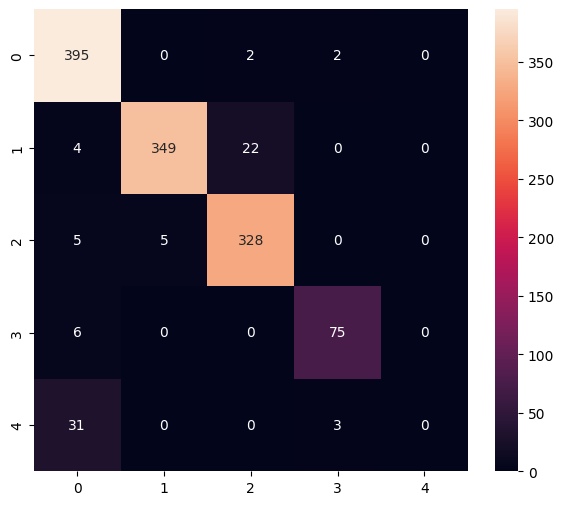

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       399
           1       0.99      0.93      0.96       375
           2       0.93      0.97      0.95       338
           3       0.94      0.93      0.93        81
           4       1.00      0.00      0.00        34

    accuracy                           0.93      1227
   macro avg       0.95      0.76      0.76      1227
weighted avg       0.94      0.93      0.92      1227



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, zero_division=1))  # Modified line

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmp_m_10zqt\assets


INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmp_m_10zqt\assets


Saved artifact at 'C:\Users\LENOVO\AppData\Local\Temp\tmp_m_10zqt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2984907479312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2984139035984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2984134748752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2984134748368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2984134750480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2984907628880: TensorSpec(shape=(), dtype=tf.resource, name=None)


6580

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.6019973  0.06642767 0.00731183 0.12778157 0.19648159]
0
